# Prelims

In [1]:
# -----------------MAGIC COMMANDS---------------
# magic commands to enable autoreload for imported packages
%load_ext autoreload
%autoreload 2
%matplotlib inline

# -------------------IMPORTS---------------------
# basic project related stuff
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..')) # setting parent_dir in sys.path
sys.path.insert(0, parent_dir) # so that tennis_main can be found as a module

# importing classes and methods
from tennis_main.data import Tennis
    
# basic EDA
# import ydata_profiling # basic EDA package
import pandas as pd
import numpy as np

# viz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import plotly.express as px
from statsmodels.graphics.gofplots import qqplot # quantile-quantile plot for gaussianity check

# data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

# model evaluation
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, learning_curve
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

# feature evaluation
from sklearn.inspection import permutation_importance

# model
from sklearn.linear_model import LogisticRegression

# Data

In [2]:
singles = Tennis().get_singles()
# doubles = Tennis().get_doubles()
players = Tennis().get_players()
rankings = Tennis().get_rankings()

# View of Singles dataframe

In [3]:
singles_2010 = singles[2010]

In [4]:
# singles_2010.describe().T

In [5]:
# singles_2010.info()

# Data Cleaning

## Checking duplicates

In [6]:
singles_2010.duplicated().sum()

np.int64(0)

## Missing Data

**A few thoughts on how to deal with missing data**

- <u>Winner and Loser seed<u>

Refers to the player's seeding in the tournament. Players are "seeded" based on their ranking to ensure that the highest ranked players do not face each other in the early rounds. There is a clear pattern in this dataframe that the loser is unseeded more often. Ths indicates that the Nan values come because of rankings. When a player is higher in the rankings than the cutoff of the tournament, they automatically qualify for it. Protected Ranking also has its identifier (PR)
*How should we deal with these missing values (58% and 78% respectively)? It is obvious that they hold predicting power for the outcome of a match*

- <u>Winner and Loser entry<u>

Refers to the way the player entered the tournament, for example through qualifiers, through a wild card etc. Again, here there is a pattern that the winner has more NaN values, which may be linked to the fact that the winner has entered the tournament through their ranking possibly? This should be investigated. It potentially holds predicting power. We will assume that all the NaN values are due to the rankings and hence, filled with "R".

- <u>Winner and Loser ht<u>

Refers to the height of the player, which obviously for some people is unknown. Possibly not too important, and has less than 5% data missing, so it could be filled with the mean.

- <u>Minutes, aces, double faults, etc <u>

All these are match statistics that are missing. They hold important value, however, they would obviously not be available beforehand if one is to predict the outcome of a match. Hence, as a first step they can be dropped, and possibly reconsidered down the line, when player specific stats up to that point in time can be engineered. Still, as NaN values they cannot be filled with anything of real value.

- <u> Winner and Loser Rank and rank points <u>

Probably the missing values are values of players that were not even ranked before the tournament. There again is a pattern that losers are missing their rank more often, which supports this hypothesis. Could all be filled by a number that is bigger than the current last ranked player, to preserve order

In [7]:
singles_2010.isnull().sum()/len(singles_2010)

tourney_id            0.000000
tourney_name          0.000000
surface               0.000000
draw_size             0.000000
tourney_level         0.000000
tourney_date          0.000000
match_num             0.000000
winner_id             0.000000
winner_seed           0.576898
winner_entry          0.894059
winner_name           0.000000
winner_hand           0.000000
winner_ht             0.020792
winner_ioc            0.000000
winner_age            0.000000
loser_id              0.000000
loser_seed            0.778548
loser_entry           0.799670
loser_name            0.000000
loser_hand            0.000000
loser_ht              0.043564
loser_ioc             0.000000
loser_age             0.000000
score                 0.000000
best_of               0.000000
round                 0.000000
minutes               0.113531
w_ace                 0.113531
w_df                  0.113531
w_svpt                0.113531
w_1stIn               0.113531
w_1stWon              0.113531
w_2ndWon

In [8]:
#########################################################
# dropping match statistics columns as a first approach #
#########################################################
stats_columns = ['minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
                   'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']

for stat in stats_columns:
    singles_2010.drop(columns = stat, inplace = True)



################################
# imputing player_ht with mean #
################################

# instantiating imputer
height_age_imputer = SimpleImputer(strategy = "median")

# fitting and transforming
singles_2010["winner_ht"], singles_2010["loser_ht"] = height_age_imputer.fit_transform(singles_2010[["winner_ht", "loser_ht"]]).T
singles_2010["winner_age"], singles_2010["loser_age"] = height_age_imputer.fit_transform(singles_2010[["winner_age", "loser_age"]]).T


#################################################################
# imputing player_ioc, player_hand, score and surface with mode #
#################################################################

# instantiating imputer
hand_surface_score_ioc_imputer = SimpleImputer(strategy = "most_frequent")

# fitting and transforming
singles_2010["winner_ioc"], singles_2010["loser_ioc"] = hand_surface_score_ioc_imputer.fit_transform(singles_2010[["winner_ioc", "loser_ioc"]]).T
singles_2010["winner_hand"], singles_2010["loser_hand"] = hand_surface_score_ioc_imputer.fit_transform(singles_2010[["winner_hand", "loser_hand"]]).T
singles_2010["surface"], singles_2010["score"] = hand_surface_score_ioc_imputer.fit_transform(singles_2010[["surface", "score"]]).T


##################################
# imputing player_entry with "R" #
##################################

# instantiating imputer
entry_imputer = SimpleImputer(strategy = "constant", fill_value = "R")

# fitting and transforming
singles_2010["winner_entry"], singles_2010["loser_entry"] = entry_imputer.fit_transform(singles_2010[["winner_entry", "loser_entry"]]).T



###########################################################################################
# filling player_rank with a rank that is greater than the greatest rank in the dataframe #
###########################################################################################

if not (singles_2010["winner_rank"].isna().sum() + singles_2010["loser_rank"].isna().sum()):
    max_rank = max(singles_2010["winner_rank"].max(), singles_2010["loser_rank"].max())

    # instantiating imputer
    rank_imputer = SimpleImputer(strategy = "constant", fill_value = max_rank + 1, keep_empty_features = True)

    # fitting and transforming
    singles_2010["winner_rank"], singles_2010["loser_rank"] = rank_imputer.fit_transform(singles_2010[["winner_rank", "loser_rank"]]).T
else:
    singles_2010["winner_rank"] = singles_2010["winner_rank"].fillna(value = 1)
    singles_2010["loser_rank"] = singles_2010["loser_rank"].fillna(value = 1)

##############################################
# filling unranked player rank points with 0 #
##############################################

# instantiating imputer
rank_point_imputer = SimpleImputer(strategy = "constant", fill_value = 0)

# fitting and transforming
singles_2010["winner_rank_points"], singles_2010["loser_rank_points"] = \
                rank_point_imputer.fit_transform(singles_2010[["winner_rank_points", "loser_rank_points"]]).T

### Dealing with player seed

We create a binary column to see if they were actually seeded, and for the ones that weren't, we fill it with their rank.

In [9]:
# creating binary column

singles_2010["winner_is_seeded"] = singles_2010["winner_seed"].apply(lambda x: 1 if pd.notna(x) else 0)
singles_2010["loser_is_seeded"] = singles_2010["loser_seed"].apply(lambda x: 1 if pd.notna(x) else 0)

# filling seed with rank

singles_2010["winner_seed"] = singles_2010.apply(lambda row: row["winner_rank"] if pd.isna(row["winner_seed"]) else row["winner_seed"], axis=1)
singles_2010["loser_seed"] = singles_2010.apply(lambda row: row["loser_rank"] if pd.isna(row["loser_seed"]) else row["loser_seed"], axis = 1)

In [10]:
# sanity check
singles_2010.isnull().sum()/len(singles_2010)

tourney_id            0.0
tourney_name          0.0
surface               0.0
draw_size             0.0
tourney_level         0.0
tourney_date          0.0
match_num             0.0
winner_id             0.0
winner_seed           0.0
winner_entry          0.0
winner_name           0.0
winner_hand           0.0
winner_ht             0.0
winner_ioc            0.0
winner_age            0.0
loser_id              0.0
loser_seed            0.0
loser_entry           0.0
loser_name            0.0
loser_hand            0.0
loser_ht              0.0
loser_ioc             0.0
loser_age             0.0
score                 0.0
best_of               0.0
round                 0.0
winner_rank           0.0
winner_rank_points    0.0
loser_rank            0.0
loser_rank_points     0.0
winner_is_seeded      0.0
loser_is_seeded       0.0
dtype: float64

In [11]:
singles_2010.sample(10)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,loser_age,score,best_of,round,winner_rank,winner_rank_points,loser_rank,loser_rank_points,winner_is_seeded,loser_is_seeded
2509,2010-D077,Davis Cup WG PO: GER vs RSA,Clay,4,D,20100917,4,104676,101.0,R,...,26.6,7-5 6-2,3,RR,101.0,515.0,159.0,300.0,0,0
1247,2010-468,Estoril,Clay,28,A,20100503,3,104268,70.0,R,...,30.6,6-4 7-6(4),3,R32,70.0,694.0,54.0,839.0,0,1
69,2010-451,Doha,Hard,32,A,20100104,8,103333,7.0,R,...,22.6,6-4 6-4,3,R32,37.0,1015.0,54.0,790.0,1,0
920,2010-403,Miami Masters,Hard,96,M,20100324,48,104417,5.0,R,...,30.5,7-6(5) 6-0,3,R64,7.0,4245.0,75.0,627.0,1,0
2627,2010-6003,Kuala Lumpur,Hard,28,A,20100927,12,104214,102.0,Q,...,26.0,6-1 6-4,3,R32,102.0,540.0,104.0,534.0,0,0
1767,2010-540,Wimbledon,Grass,128,G,20100621,97,103819,1.0,R,...,32.5,6-2 6-4 6-2,5,R32,2.0,8525.0,86.0,620.0,1,0
758,2010-D010,Davis Cup WG R1: FRA vs GER,Hard,4,D,20100305,1,104792,15.0,R,...,26.3,6-1 6-4 7-6(5),5,RR,15.0,2130.0,30.0,1305.0,0,0
646,2010-D019,Davis Cup G1 R1: CHN vs UZB,Hard,4,D,20100305,1,104797,76.0,R,...,18.4,2-6 6-3 7-5 6-4,5,RR,76.0,621.0,670.0,27.0,0,0
71,2010-451,Doha,Hard,32,A,20100104,10,103694,57.0,R,...,19.0,6-1 6-0,3,R32,57.0,757.0,1.0,0.0,0,0
483,2010-506,Buenos Aires,Clay,32,A,20100215,24,103507,2.0,R,...,31.6,6-2 6-4,3,R16,22.0,1760.0,86.0,565.0,1,0


# Engineering new features, "anonymizing" winner and creating target

We will now engineer the dataframe so that it has players as player A or player B and have a separate column for the winner, which will be the target. Player A and player B rows will be randomly interchanged so that player A is not always the winner.

Moreover, we will engineer some new features to be included in the new MVP

## Renaming and shuffling columns (to anonymize the winner)

In [12]:
# renaming columns

renamed_columns = {
    'winner_id': 'player_A_id',
    'winner_seed': 'player_A_seed',
    'winner_entry': 'player_A_entry',
    'winner_name': 'player_A_name',
    'winner_hand': 'player_A_hand',
    'winner_ht': 'player_A_ht',
    'winner_ioc': 'player_A_ioc',
    'winner_age': 'player_A_age',
    'winner_rank': 'player_A_rank',
    'winner_rank_points': 'player_A_rank_points',
    'winner_is_seeded': 'player_A_is_seeded',
    
    'loser_id': 'player_B_id',
    'loser_seed': 'player_B_seed',
    'loser_entry': 'player_B_entry',
    'loser_name': 'player_B_name',
    'loser_hand': 'player_B_hand',
    'loser_ht': 'player_B_ht',
    'loser_ioc': 'player_B_ioc',
    'loser_age': 'player_B_age',
    'loser_rank': 'player_B_rank',
    'loser_rank_points': 'player_B_rank_points',
    'loser_is_seeded': 'player_B_is_seeded',
}

singles_2010 = singles_2010.rename(columns=renamed_columns)

# creating winner column

singles_2010["winner_id"] = singles_2010['player_A_id'].copy()

# randomly swapping columns so that player A is not always the winner

columns_to_swap = [
    'player_A_id', 'player_B_id',
    'player_A_seed', 'player_B_seed',
    'player_A_entry', 'player_B_entry',
    'player_A_name', 'player_B_name',
    'player_A_hand', 'player_B_hand',
    'player_A_ht', 'player_B_ht',
    'player_A_ioc', 'player_B_ioc',
    'player_A_age', 'player_B_age',
    'player_A_rank', 'player_B_rank',
    'player_A_rank_points', 'player_B_rank_points',
    'player_A_is_seeded', 'player_B_is_seeded',
]

# creating seed and an array of boolean values with the same length as the dataframe.
# the boolean values decide which rows will have player A and player B swapped

np.random.seed(2010)
swap_mask = np.random.choice([True, False], size=len(singles_2010))

# making the swap
for col_A, col_B in zip(columns_to_swap[::2], columns_to_swap[1::2]):
    singles_2010.loc[swap_mask, [col_A, col_B]] = singles_2010.loc[swap_mask, [col_B, col_A]].values

# creating winner column with 0 or 1 depending on player A or B having won
singles_2010["winner"] = singles_2010.apply(lambda row: 0 if row["winner_id"] == row["player_A_id"] else 1, axis = 1)

## Engineering new features

New features related to the difference in age, height, rank and rank points are created

In [13]:
singles_2010.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'player_A_id', 'player_A_seed',
       'player_A_entry', 'player_A_name', 'player_A_hand', 'player_A_ht',
       'player_A_ioc', 'player_A_age', 'player_B_id', 'player_B_seed',
       'player_B_entry', 'player_B_name', 'player_B_hand', 'player_B_ht',
       'player_B_ioc', 'player_B_age', 'score', 'best_of', 'round',
       'player_A_rank', 'player_A_rank_points', 'player_B_rank',
       'player_B_rank_points', 'player_A_is_seeded', 'player_B_is_seeded',
       'winner_id', 'winner'],
      dtype='object')

In [14]:
singles_2010["height_diff"] = singles_2010["player_A_ht"] - singles_2010["player_B_ht"]
singles_2010["age_diff"] = singles_2010["player_A_age"] - singles_2010["player_B_age"]
singles_2010["rank_diff"] = singles_2010["player_A_rank"] - singles_2010["player_B_rank"]
singles_2010["rank_point_diff"] = singles_2010["player_A_rank_points"] - singles_2010["player_B_rank_points"]

# Picking Features

For the MVP we aim to create here, we drop not only the statistics of each match, as before, but a few more features to make a simple model, that is mainly based on the surface, on the player rank and seeding stats, their hand and their age.

In [15]:
singles_2010.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'player_A_id', 'player_A_seed',
       'player_A_entry', 'player_A_name', 'player_A_hand', 'player_A_ht',
       'player_A_ioc', 'player_A_age', 'player_B_id', 'player_B_seed',
       'player_B_entry', 'player_B_name', 'player_B_hand', 'player_B_ht',
       'player_B_ioc', 'player_B_age', 'score', 'best_of', 'round',
       'player_A_rank', 'player_A_rank_points', 'player_B_rank',
       'player_B_rank_points', 'player_A_is_seeded', 'player_B_is_seeded',
       'winner_id', 'winner', 'height_diff', 'age_diff', 'rank_diff',
       'rank_point_diff'],
      dtype='object')

In [16]:
drop_cols = ["tourney_id", "tourney_name", "tourney_date",  "player_A_id", "player_B_id", "player_A_name", "player_B_name", 
             "player_A_ioc", "player_B_ioc", "score", "match_num", "winner_id"]

singles_2010.drop(columns = drop_cols, inplace = True)

# Feature Scaling

## Outliers and gaussianity

In [17]:
number_cols = singles_2010.select_dtypes(include = np.number).columns.to_list()

In [18]:
# for col in number_cols:
#     fig, ax = plt.subplots(1,3,figsize=(15,5))

#     ax[0].set_title(f"Distribution of {col}")
#     sns.histplot(data = singles_2010, x = f"{col}", kde=True, ax = ax[0])

#     ax[1].set_title(f"Boxplot of {col}")
#     sns.boxplot(data = singles_2010, x = f"{col}", ax=ax[1])

#     ax[2].set_title(f"Gaussianity of {col}")
#     qqplot(singles_2010[f"{col}"],line='s',ax=ax[2]);

## Scaling

In [19]:
# features to be StandardScaled (they have only a few outliers and are gaussianly distributed)
feats_to_std_scale = ["rank_point_diff", "rank_diff", "age_diff", "height_diff"]

# features to be RobustScaled (they have outliers and/or non gaussian distribution)
feats_to_rob_scale = ["player_A_rank_points", "player_B_rank_points",
                      "player_A_rank", "player_B_rank", "player_A_ht", "player_B_ht", "player_A_seed", 
                      "player_B_seed", "draw_size", "player_A_age", "player_B_age"]

# features to be Normalized (they are ordinal and don't have outliers)
feats_to_minmax_scale = []

# all feats to be scaled, for later use
scaled_feats = feats_to_std_scale + feats_to_rob_scale + feats_to_minmax_scale

# features to drop from scaling and do encoding instead
num_feats_to_encode = ["best_of"]

# features and target
cols = list(singles_2010.columns)
cols.remove("winner")

X = singles_2010[cols]
y = singles_2010["winner"]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2010)

# instantiating scalers
rob_scaler = RobustScaler()
std_scaler = StandardScaler()

# fitting to train set ONLY!
rob_scaler.fit(X_train[feats_to_rob_scale])
std_scaler.fit(X_train[feats_to_std_scale])

# transforming
X_train[feats_to_rob_scale] = rob_scaler.transform(X_train[feats_to_rob_scale])
X_test[feats_to_rob_scale] = rob_scaler.transform(X_test[feats_to_rob_scale])

X_train[feats_to_std_scale] = std_scaler.transform(X_train[feats_to_std_scale])
X_test[feats_to_std_scale] = std_scaler.transform(X_test[feats_to_std_scale])

In [20]:
# sanity check
# X_train[feats_to_std_scale]

# Encoding

In [21]:
# features to be encoded
feats_to_encode = X_train.select_dtypes(include = "object").columns.to_list()
feats_to_encode.append("best_of")

# instantiating encoder
ohe = OneHotEncoder(sparse_output = False, drop = "first") # we drop the first category for each feature encoded, to reduce complexity

# fitting to train set ONLY!
ohe.fit(X_train[feats_to_encode])

# transforming
X_train_encoded = ohe.transform(X_train[feats_to_encode])
X_test_encoded = ohe.transform(X_test[feats_to_encode])

# converting into dataframes
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names_out())
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names_out())

# resetting indices
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
y_train = y_train.reset_index().drop(columns = "index")
y_test = y_test.reset_index().drop(columns = "index")

# recombining
X_train_combined = pd.concat([X_train[scaled_feats], X_train_encoded_df], axis=1)
X_test_combined = pd.concat([X_test[scaled_feats], X_test_encoded_df], axis=1)

# Feature Selection

## Correlation Matrix Heatmap

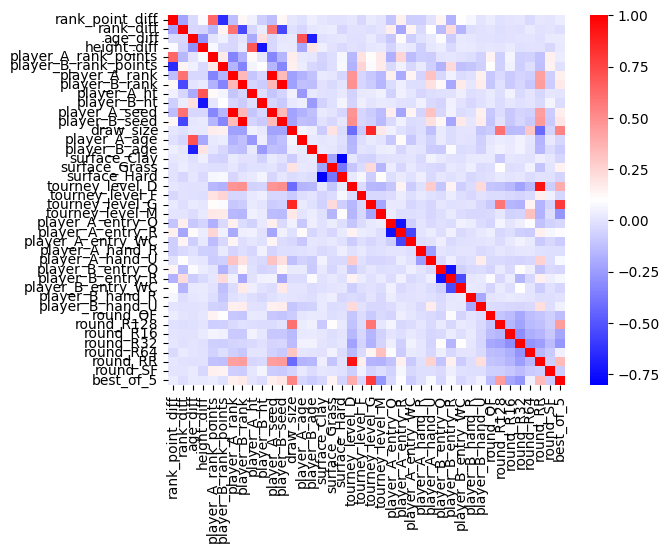

In [22]:
correlation_matrix = X_train_combined.select_dtypes('number').corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr");

## Correlation Matrix

In [23]:
# converting correlation matrix into a df
corr_df = correlation_matrix.stack().reset_index()

# renaming columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# removing self-correlations
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [24]:
# computing absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# showing top 5 most correlated pairs of features
corr_df.sort_values(by="absolute_correlation", ascending=False).head(5*2)

,feature_1,feature_2,correlation,absolute_correlation
250,player_A_rank,player_A_seed,0.997861,0.997861
406,player_A_seed,player_A_rank,0.997861,0.997861
447,player_B_seed,player_B_rank,0.997290,0.997290
291,player_B_rank,player_B_seed,0.997290,0.997290
1498,round_RR,tourney_level_D,0.933010,0.933010
757,tourney_level_D,round_RR,0.933010,0.933010
812,tourney_level_G,draw_size,0.861726,0.861726
500,draw_size,tourney_level_G,0.861726,0.861726
617,surface_Clay,surface_Hard,-0.802818,0.802818
695,surface_Hard,surface_Clay,-0.802818,0.802818


## Dropping player seed and a few more correlated columns

The diff columns create a perfect correlation between the corresponding player features, so they must be dropped. also dropping the seed which is perfectly correlated with the rank. Dropping Clay surface because it demonstrated a very high VIF for some reason.

In [25]:
X_train_combined = X_train_combined.drop(columns = ["player_A_seed", "player_B_seed", "tourney_level_D", "tourney_level_G", "player_A_age", \
                                                   "player_A_ht", "player_A_rank", "player_A_rank_points", "surface_Clay"])
X_test_combined = X_test_combined.drop(columns = ["player_A_seed", "player_B_seed", "tourney_level_D", "tourney_level_G", "player_A_age", \
                                                   "player_A_ht", "player_A_rank", "player_A_rank_points", "surface_Clay"])

## VIF to check for multicolinearity

In [26]:
X_train_const = add_constant(X_train_combined)
vif_df = pd.DataFrame()
vif_df["features"] = X_train_const.columns
vif_df["VIF"] = [vif(X_train_const.values, i) for i in range(X_train_const.shape[1])]
vif_df

,features,VIF
0,const,202.146672
1,rank_point_diff,2.620076
2,rank_diff,2.041575
3,age_diff,2.273282
4,height_diff,2.399076
5,player_B_rank_points,3.494354
6,player_B_rank,2.749638
7,player_B_ht,2.377515
8,draw_size,6.682097
9,player_B_age,2.316677


# MVP (Logistic Regression)

## CV

In [27]:
# instantiating model
log_reg = LogisticRegression(max_iter = 1000)

# cross_val
cv_results = cross_validate(log_reg, X_train_combined, y_train.squeeze(), cv = 5) # converting df to serie so i don't get the annoying warning

In [28]:
cv_results

{'fit_time': array([0.04712868, 0.02447367, 0.02275538, 0.02237606, 0.02357674]),
 'score_time': array([0.00332499, 0.00328612, 0.00318813, 0.00314951, 0.00316024]),
 'test_score': array([0.60705882, 0.66745283, 0.66037736, 0.69575472, 0.62028302])}

## Evaluation with test set

In [29]:
# instantiating model
log_reg = LogisticRegression(max_iter = 1000)

# training
log_reg.fit(X_train_combined, y_train.squeeze())

# evaluating
log_reg.score(X_test_combined,y_test)

0.6677667766776678

## Feature permutation

In [30]:
# performing permutation
permutation_score = permutation_importance(log_reg, X_train_combined, y_train, n_repeats=10)

# unstacking results showing the decrease in performance after shuffling
importance_df = pd.DataFrame(np.vstack((X_train_combined.columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

# showing features' importance
importance_df.sort_values(by="score decrease", ascending=False)

,feature,score decrease
0,rank_point_diff,0.106506
14,player_A_entry_R,0.030646
2,age_diff,0.010608
27,round_R64,0.009288
1,rank_diff,0.008487
13,player_A_entry_Q,0.007732
15,player_A_entry_WC,0.007025
19,player_B_entry_R,0.006412
21,player_B_hand_R,0.005941
5,player_B_rank,0.004998


# Learning Curves

In [31]:
# joining X_train and X_test to feed to the learning curves algorithm
X_new = pd.concat([X_train_combined, X_test_combined]).reset_index(drop = True)
y_new = pd.concat([y_train, y_test]).reset_index(drop = True)

# spliting in train sizes up to 70% of the total data
train_sizes = [round(coef*len(X_new)/100) for coef in range(1,72,10)]

# getting scores, sizes and test scores
train_sizes, train_scores, test_scores = learning_curve(
    estimator=LogisticRegression(), X=X_new, y=y_new.squeeze(), train_sizes=train_sizes, cv=5)

# means of cv train and test
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

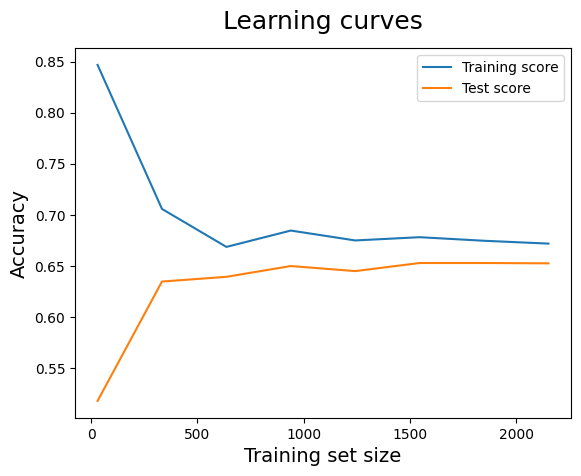

In [32]:
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

# Notes

**Judging by the results of this Logistic Regression**

At least from a linear model's perspective,
- Player hand seems to not affect the model too much. However, it is an unbalanced feature and possibly the signal it creates might not be important enough. *Maybe we should compensate by engineering a same_hand feature, instead of what we have now*.
- Round and entry, as well as draw size, and tourney level seem to not be important from a linear model's perspective.

The learning curves converge, but they converge quite low so we have some underfitting. This points towards using more data, which we have an abundance of, creating more features like player statistics or changing the model.